1. find the correct expression of the normalization constant in Eq. (8)

In [3]:
import numpy as np
import scipy
import sys
import math
import scipy.special
import scipy.constants as const
from math import factorial
from scipy.special import hermite
import matplotlib.pyplot as plt

In [4]:
#constants

v_0R = 200 #Mev
v_0t = 178 #Mev
v_0s = 91.85 #Mev

k_R = 1.487 #fm^-2 should we change in A?
k_t = 0.639 #fm^-2
k_s = 0.465 #fm^-2

# - Radial wavefunction parameters
nu = [0.1] #fm^-2
n_max = 20 #maximum value of the order of the radial part of the wavefunction

m_p = 938.272 # mass of proton in MeV/c^2
m_n = 939.565 # mass of neutron in MeV/c^2
m_e = 0.511 # mass of electron in MeV/c^2
mu = m_p*m_n/(m_p+m_n) #reduced mass in amu

h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*mu) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
print(a) #eV*Angstrom^2, 

4.158398182328096


In [5]:

def norm_constant(n,nu):
    '''
    this function returns the normalisation constant for the n-th order radial wavefunction 
    '''
    denom = 4*np.pi**(3/2) * 2**(2*n+1) / (2*nu)**0.5 * factorial(2*n+1)
    return (2 / denom)**(1/2) #the factor sqrt 2 comes from hermites being even, and our given normalisation being between -inf and +inf

def R_n(n,r,nu):
    '''
    this function returns the n-th order radial wf of eigenstates of 3d HO
    '''
    return norm_constant(n,nu)* np.exp(-nu*r**2)* hermite(2*n+1)((2*nu)**0.5*r) / r

# Function that show graphically the elements of the matrix
def draw_matrix(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()

Normalizing our space states $\psi_j(\mathbf{r})$, namely $\int d\mathbf{r} |\psi_j(\mathbf{r})|^2=1$ we obtain the analytical expression for $\tilde{N_n}$:
$$
\tilde{N}_n= \dfrac{(2\nu)^{1/4}}{2\pi^{3/4}\sqrt{(2n+1)!}}2^{-n}
$$.

Check normalisation, change n1 and n2 to see if the radial wf's are orthonormal

In [6]:
n1 = 5
n2 = 5
nu = 1

r = np.linspace(0.1, 10, 1000)

R1 = [R_n(n1, r, nu) for r in r]
R2 = [R_n(n2, r, nu) for r in r]

integrand = [4*np.pi*r1 * r2 * r**2 for r1, r2, r in zip(R1, R2, r)]

norm = np.trapz(integrand, r)
print("The scalar product between the",n1, "wavefunction and the", n2, "wavefunction is",norm)

The scalar product between the 5 wavefunction and the 5 wavefunction is 0.9947270635579459


## Matrix elements

## Working on spin-isospin

The four possible states of spin-isospin $\Phi_j (\sigma_1,\tau_1,\sigma_2, \tau_2)$ of our system are 

\begin{align*}
|\Phi_A \rangle &= \frac{1}{\sqrt{2}} \left( \ket{\uparrow \uparrow \uparrow \downarrow} - \ket{\uparrow \downarrow \uparrow \uparrow} \right) \\
|\Phi_B \rangle &= \frac{1}{\sqrt{2}} \left( \ket{\uparrow \uparrow \downarrow \downarrow} - \ket{\downarrow \downarrow \uparrow \uparrow} \right) \\
|\Phi_C \rangle &= \frac{1}{\sqrt{2}} \left( \ket{\downarrow \uparrow \downarrow \downarrow} - \ket{\downarrow \downarrow \downarrow \uparrow} \right) \\
|\Phi_D \rangle &= \frac{1}{\sqrt{2}} \left( \ket{\downarrow \uparrow \uparrow \downarrow} - \ket{\uparrow \downarrow \downarrow \uparrow} \right)
\end{align*}

In [7]:
#DEFINING THE STATES
up = 1
down = -1
prefactor = 1 / np.sqrt(2)
# A = (|↑↑↑↓⟩ − |↑↓↑↑⟩)
A = [ ((up, up, up, down), prefactor), ((up, down, up, up), -prefactor) ]

# B = (|↑↑↓↓⟩ − |↓↓↑↑⟩)
B = [ ((up, up, down, down), prefactor), ((down, down, up, up), -prefactor) ]

# C = (|↓↑↓↓⟩ − |↓↓↓↑⟩)
C = [ ((down, up, down, down), prefactor), ((down, down, down, up), -prefactor) ]

# D = (|↓↑↑↓⟩ − |↑↓↓↑⟩)
D = [ ((down, up, up, down), prefactor), ((up, down, down, up), -prefactor)] 


Spin-isopsin functions to evaluate 4x4 potential matrix

In [8]:
# Compute inner product between two spin states

def inner_product(state1, state2):
    total = 0
    for (s1, c1) in state1: #represent full basis states: s1 = (down, up, down, down) for example
        for (s2, c2) in state2:
                S1 = tuple(x for x in s1)  # multiply the coefficients with the spin states
                S2 = tuple(x for x in s2)  # multiply the coefficients with the spin states
                if S1 == S2:
                    total += c1 * c2
                    #print(total)
    return total


#check if it works
#print("Inner product is",inner_product(B,B))

def spin_exchange(state):
    exchanged_state = []
    for spin, coeff in state:
        a, b, c, d = spin  # Unpack the original spin tuple (safe and clean)
        new_spin = (c, b, a, d)  # Swap the first three elements
        exchanged_state.append((new_spin, coeff))
    return exchanged_state

#print("Inner product is",inner_product(B,spin_exchange(D)))

def V_R(r):
    return v_0R * np.exp(-k_R*r**2) # MeV

def V_t(r):
    return v_0t * np.exp(-k_t*r**2) # MeV

def V_s(r):
    return v_0s * np.exp(-k_s*r**2) # MeV


def V_matrix_elements(state1, state2, r):
    '''
    This function returns the potential energy between two states at a distance r.
    '''
    # Apply spin exchange to state2
    exchanged_state2 = spin_exchange(state2)
    
    # Compute the two potential terms (you may need to adjust this depending on the context)
    V_t_value = V_t(r)
    V_s_value = V_s(r)
    
    Vij =  inner_product(state1,state2)
    Vij_P = inner_product(state1, exchanged_state2)

    return (0.5 * (Vij + Vij_P) * V_t_value + 0.5 * (Vij - Vij_P) * V_s_value) 

#r = 1.0  # radial distance in fm
#print("The potential energy between A and B is", V_matrix_elements(B,D,r))

def V_matrix_elements_str(state1, state2):
    """
    Returns the potential matrix element ⟨state1|V|state2⟩ as a string,
    using symbolic expressions for V_t(r) and V_s(r) which will help us to built gauss-hermite integral's coefficients.
    """
    # Apply spin exchange
    exchanged_state2 = spin_exchange(state2)

    # Inner products (assumed numeric)
    Vij   = inner_product(state1, state2)
    Vij_P = inner_product(state1, exchanged_state2)

    # Build symbolic string
    term_t = f"(0.5*({Vij} + {Vij_P}))*V_t(r)"
    term_s = f"(0.5*({Vij} - {Vij_P}))*V_s(r)"

    return f"{term_t} + {term_s}"

Showing results

In [18]:
states = [A, B, C, D]
labels = ["A", "B", "C", "D"]

r = 1.0  # radial distance in fm

# Compute the full matrix
matrix = np.zeros((4, 4))

for i, state_i in enumerate(states):
    for j, state_j in enumerate(states):
        matrix[i, j] = V_matrix_elements(state_i, state_j,r)

# Display results nicely
print("Matrix elements ⟨X|V(r)|Y⟩ with r =", r, "fm\n")
for i in range(4):
    for j in range(4):
        print(f"⟨{labels[i]}|V|{labels[j]}⟩ = {matrix[i,j]: .4f} MeV")
    print()

Matrix elements ⟨X|V(r)|Y⟩ with r = 1.0 fm

⟨A|V|A⟩ =  93.9520 MeV
⟨A|V|B⟩ =  0.0000 MeV
⟨A|V|C⟩ =  0.0000 MeV
⟨A|V|D⟩ =  0.0000 MeV

⟨B|V|A⟩ =  0.0000 MeV
⟨B|V|B⟩ =  75.8231 MeV
⟨B|V|C⟩ =  0.0000 MeV
⟨B|V|D⟩ =  18.1289 MeV

⟨C|V|A⟩ =  0.0000 MeV
⟨C|V|B⟩ =  0.0000 MeV
⟨C|V|C⟩ =  93.9520 MeV
⟨C|V|D⟩ =  0.0000 MeV

⟨D|V|A⟩ =  0.0000 MeV
⟨D|V|B⟩ =  18.1289 MeV
⟨D|V|C⟩ =  0.0000 MeV
⟨D|V|D⟩ =  75.8231 MeV



In [9]:
# Drawing of the Potential matrix
draw_matrix(matrix)

NameError: name 'matrix' is not defined

By looking how the operator $\hat{P}^{\sigma}$ acts on our states:
$$
 \hat{P}^{\sigma}|\phi_A \rangle = \hat{P}^{\sigma} \frac{1}{\sqrt{2}}(|\uparrow \uparrow \uparrow \downarrow \rangle - |\uparrow \downarrow \uparrow \uparrow  \rangle) = \frac{1}{\sqrt{2}}(|\uparrow \uparrow \uparrow \downarrow \rangle - |\uparrow \downarrow \uparrow \uparrow  \rangle) = |\phi_A \rangle
$$
$$
 \hat{P}^{\sigma}|\phi_B \rangle =  |\phi_D \rangle
$$
$$
 \hat{P}^{\sigma}|\phi_C \rangle =  |\phi_C \rangle
$$
$$
 \hat{P}^{\sigma}|\phi_D \rangle =  |\phi_B \rangle
$$
we see the code working well as we expect only B and D states to be coupled by the potential.

To evaluate the matrix elements of the operator 
$$
\hat{V}=V_{R}(r)+\frac{1}{2}(1+\hat{P}^{\sigma})V_t(r)+\frac{1}{2}(1-\hat{P}^{\sigma})V_s(r)
$$
on the full Hilbert space we have to first act with spin-isospin states and then integrate over the radial coordiante. 
$$
\langle mj |\hat{V} |ni \rangle =
$$
$$
\tilde{N}_m(\nu) \tilde{N}_n(\nu) \delta_{j,i} \left[ \int_{0}^{\infty} dr v_{0r}e^{-(2 \nu + k_R)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r) + \int_{0}^{\infty} dr v_{0t}e^{-(2 \nu + k_T)r^2} H_{2n+1}(\sqrt{2 \nu} r) H_{2m+1}(\sqrt{2 \nu} r) \right]
$$
This integrals involve a product between Hermite polynomials times a gaussian, to solve them we use the Gauss-Hermite quadrature. By changing variable $((2 \nu + k)r^2)=x^2$ we get the general form 
$$
I=\frac{1}{2 \sqrt{2 \nu + k}} \int_{-\infty}^{\infty} dx  \ v \ e^{-x^2} H_{2n+1}\left(x\sqrt{\frac{2 \nu}{2 \nu + k}}\right) H_{2m+1}\left(x\sqrt{\frac{2 \nu}{2 \nu + k}}\right)
$$
The Gauss-Hermite quadrature states that
$$
I\simeq \frac{v}{2\sqrt{2\nu +k}}\Sigma _{i=1} ^n w_i \cdot H_{2n+1}\left(x_i\sqrt{\frac{2 \nu}{2 \nu + k}}\right)\cdot H_{2m+1}\left(x_i\sqrt{\frac{2 \nu}{2 \nu + k}}\right),
$$
where $n$ is the number of points sampled used, $w_i= \frac{2^{n-1}n!\sqrt{\pi}}{n^2 [H_{n-1}(x_i)]^2}$ and $x_i$ are the points of quadrature (controls accuracy; more = better).

In [10]:
# Quadrature integrals
def gauss_hermite_integration(func, n,k,i,j,nu):
    # nodes and weights for the gaussian quadrature
    nodes, weights = np.polynomial.hermite.hermgauss(n)

    # evaluate the function in the nodes and do the sum
    integral = np.sum(weights * func(nodes,k,i,j,nu))

    return integral

# Function to quadrature
def Hermite_product(x,k,i,j,nu):
  """product of hermite polinomyals of order 2i+1 and 2j+1 evaluated in x*(expression that depends on nu and k), k depends on V_t or V_s"""
  return hermite(2*i+1)(x*np.sqrt(2*nu/(2*nu+k)))*hermite(2*j+1)(x*np.sqrt(2*nu/(2*nu+k)))

# Function that show graphically the elements of the matrix
def draw_matrix(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()


The following code section will help us evaluating the contributes of the radial potential after the smashing of spin-isospins states.

In [21]:
states = [A, B, C, D]
labels = ["A", "B", "C", "D"]

matrix = np.zeros((4, 4), dtype=object)

for i, state_i in enumerate(states):
    for j, state_j in enumerate(states):
        matrix[i, j] = V_matrix_elements_str(state_i, state_j)

print(f"Matrix elements ⟨X|V(r)|Y⟩\n")

for i in range(4):
    for j in range(4):
        print(f"⟨{labels[i]}|V|{labels[j]}⟩ = {matrix[i, j]}")
    print()

Matrix elements ⟨X|V(r)|Y⟩

⟨A|V|A⟩ = (0.5*(0.9999999999999998 + 0.9999999999999998))*V_t(r) + (0.5*(0.9999999999999998 - 0.9999999999999998))*V_s(r)
⟨A|V|B⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨A|V|C⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨A|V|D⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)

⟨B|V|A⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨B|V|B⟩ = (0.5*(0.9999999999999998 + 0))*V_t(r) + (0.5*(0.9999999999999998 - 0))*V_s(r)
⟨B|V|C⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨B|V|D⟩ = (0.5*(0 + 0.9999999999999998))*V_t(r) + (0.5*(0 - 0.9999999999999998))*V_s(r)

⟨C|V|A⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨C|V|B⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨C|V|C⟩ = (0.5*(0.9999999999999998 + 0.9999999999999998))*V_t(r) + (0.5*(0.9999999999999998 - 0.9999999999999998))*V_s(r)
⟨C|V|D⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)

⟨D|V|A⟩ = (0.5*(0 + 0))*V_t(r) + (0.5*(0 - 0))*V_s(r)
⟨D|V|B⟩ = (0.5*(0 + 0.9999999999999998))*V_t(r) + (0.5*(0 - 0.9

In [11]:
# Potential Matrix

V_matrix = np.zeros((n_max*4, n_max*4))

nu = [0.1] #fm^-2 #I need to copy it here otherwise it doesn't work :)

# Allocation of the values in the matrix
for n in range(n_max):
  for m in range(n_max):
    N_nu_n = norm_constant(n,nu[0])
    N_nu_m = norm_constant(m,nu[0])
    const = N_nu_n*N_nu_m
    n_nodes = 2*(2*n+1+2*m+1) #2*(the sum of the order of the Hermite polynomial)
    for k in range(4):
      if k==0 or k==2:
        int1 = v_0R/(2*np.sqrt(2*nu[0]+k_R))*gauss_hermite_integration(Hermite_product, n_nodes,k_R,n,m,nu[0])
        int2 = -v_0t/(2*np.sqrt(2*nu[0]+k_t))*gauss_hermite_integration(Hermite_product, n_nodes,k_t,n,m,nu[0])
        V_matrix[4*n+k, 4*m+k] = const*(int1+int2)
      if k==1 or k==3:
        int1 = v_0R/(2*np.sqrt(2*nu[0]+k_R))*gauss_hermite_integration(Hermite_product, n_nodes,k_R,n,m,nu[0])
        int2 = -0.5*v_0t/(2*np.sqrt(2*nu[0]+k_t))*gauss_hermite_integration(Hermite_product, n_nodes,k_t,n,m,nu[0])
        int3 = -0.5*v_0s/(2*np.sqrt(2*nu[0]+k_s))*gauss_hermite_integration(Hermite_product, n_nodes,k_s,n,m,nu[0])
        V_matrix[4*n+k, 4*m+k] = const*(int1+int2+int3)
      if k==1:
        V_matrix[4*n+k, 4*m+2+k] = const*(int2-int3)
        V_matrix[4*n+2+k, 4*m+k] = const*(int2-int3)

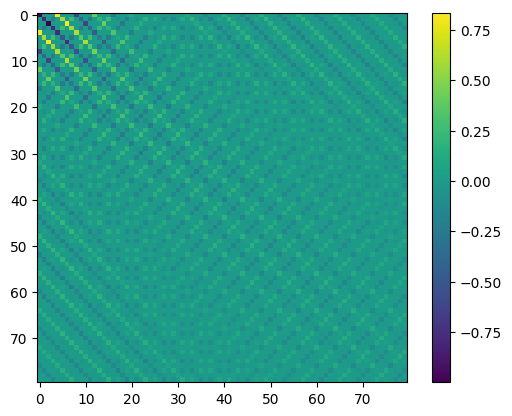

In [12]:
#Drawing Potential matrix
draw_matrix(V_matrix)

   \begin{align*}
      \bra{mj} \hat{K} \ket{nk}   &= 4\pi \delta_{jk} \int dr r^2 R_m \left(-\frac{\hbar
      ^2 \nabla ^2 }{2\mu} R_n\right) \nonumber \\ 
      &= -\frac{4\pi \hbar ^2}{2\mu} \delta_{jk} \tilde{N}_m (\nu) \tilde{N}_n (\nu) \int
      dr e^{-\nu r^2} H_{2m+1} (\sqrt{2\nu} r) \frac{\partial ^2}{\partial r^2}
      \left(e^{-\nu r^2}H_{2n+1}(\sqrt{2\nu} r)\right)\nonumber \\ 
      &= -\frac{4\pi \hbar ^2}{\mu} \delta_{jk} \tilde{N}_m (\nu) \tilde{N}_n (\nu) \int
      dr e^{-2\nu r^2} H_{2m+1} (\sqrt{2\nu} r) 
      \left(\left(x^2-1\right)H_{2n+1} - 2x H_{2n+1}^\prime + H_{2n+1}^{\prime\prime}\right)\nonumber \\ 
      &= -\frac{4\pi \hbar ^2}{\mu} \delta_{jk} \tilde{N}_m \tilde{N}_n \int
      dr e^{-2\nu r^2} H_{2m+1} \left(x^2 H_{2n+1} - H_{2n+1} - 4(2n+1) xH_{2n} +
      4n\left(2n+1\right)H_{2n-1}\right)
      \end{align*} 

and use $2xH_n = H_{n+1} + 2n H_{n-1}$:
\begin{align*}
      \bra{mj} \hat{K} \ket{nk} &= \frac{-4\pi \hbar ^2}{\mu}\delta_{jk}\tilde{N}_n\tilde{N}_m \int dr e^{-2\nu
r^2}H_{2m+1} \left(\frac{1}{4}H_{2n+3} -\frac{1}{2} \left(4n+3\right)H_{2n+1} -
2n(n+1) H_{2n+1}\right)\nonumber \\ 
&= \frac{-\nu \hbar ^2}{\mu} \delta_{jk} \bra{m}
\left(\frac{\tilde{N}_n}{4\tilde{N}_{n+1}}\ket{n} -
\frac{1}{2}\left(4n+3\right)\ket{n} - 2n(2n+1)
\frac{\tilde{N}_n}{\tilde{N}_{n-1}}\ket{n-1} \right)
\end{align*}
or
\begin{align*}
\bra{mj} \hat{K} \ket{nk} &= \frac{\hbar \nu}{2\mu}\delta_{jk}
\left[\left(4n+3\right)\delta_{mn} - \sqrt{(2n+3)(2n+2)} \delta_{n,m-1} -
\sqrt{2n(2n+1)}\delta_{n,m+1} \right]
\end{align*}


In [47]:
#Kinetic matrix

K_matrix = np.zeros((n_max, n_max))
K_matrix_comp = np.zeros((n_max, n_max))


a = 1e-12* h_bar**2 *(c*1e15)**2/(2*m) #1e-12 for conversion eV**2 -> MeV - 1e-15 for conversion m -> fm
#allocation of the values in the matrix

for n in range(n_max):
    for m in range(n_max):
        if m == n: #diagonal elements
            K_matrix[n, m] = a * nu * (4*n+3)
        if m == n-1: #upper diagonal elements
            K_matrix[n, m] = - a * nu * ((2*n+2)*(2*n+3))**(1/2)
        if m == n+1: #lower diagonal elements
            K_matrix[n, m] = - a * nu * (2*n*(2*n+1))**(1/2)



In [32]:
num_rows = n_max
num_cols = n_max

kin_matrix = np.zeros((num_rows, num_cols))
# Allocation of the values in the matrix
for n in range(n_max):
    for m in range(n_max):
      if n==m:
        kin_matrix[n, m] = a*nu*(4*n+3)
      elif n==m+1:
        kin_matrix[n, m] = -a*nu*np.sqrt(2*n*(2*n+1))
      elif n+1==m:
        kin_matrix[n, m] = -a*nu*np.sqrt((2*n+2)*(2*n+3))

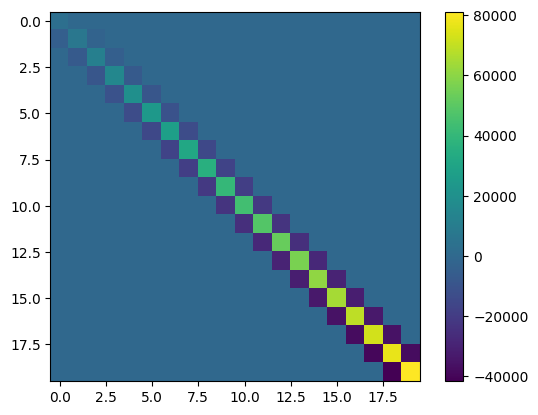

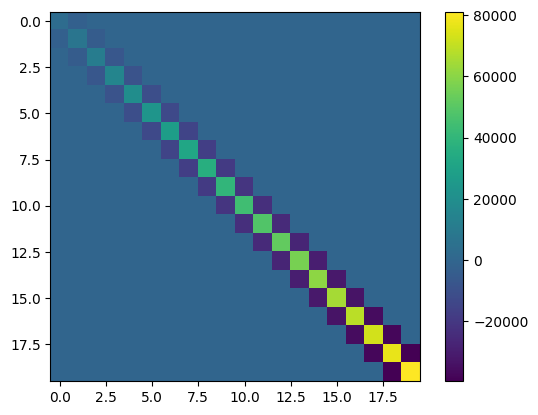

In [48]:
# Drawing of the Kinetic Energy matrix
draw_matrix(K_matrix)

draw_matrix(kin_matrix)

## Diagonalization